In [1]:
import pandas as pd
import numpy as np
import PIL
import os
import json
import cv2
import os
import numpy as np
from collections import Counter
import shutil
import sklearn
import sklearn.metrics as metrics
import pytesseract
from matplotlib.pyplot import imshow
%matplotlib inline

# Simple CNN model for CIFAR-10
import keras
from keras.layers import Dense,Dropout,Flatten, Activation,Conv1D,MaxPooling1D,LSTM,Embedding,Input,Conv2D
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.models import Model
from keras.preprocessing import sequence
from keras import backend as K

# import keras_metrics
K.set_image_data_format('channels_first')
# K.set_image_dim_ordering('th')
import tensorflow as tf
# Plot ad hoc CIFAR10 instances
from keras.datasets import cifar10
from matplotlib import pyplot
from scipy.misc import toimage


def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

@as_keras_metric
def auc_pr(y_true, y_pred, curve='PR'):
    return tf.metrics.auc(y_true, y_pred, curve=curve)

# load data
#(X_train, y_train), (X_test, y_test) = cifar10.load_data()
from IPython.display import Image

Using TensorFlow backend.


## Optical Character recognition

<b>Optical character recognition (OCR) is process of classification of opti-
cal patterns contained in a digital image. The character recognition is achieved
through segmentation, feature extraction and classification.</b>


OCR (optical character recognition) is the recognition of printed or written text characters by a computer. This involves photoscanning of the text character-by-character, analysis of the scanned-in image, and then translation of the character image into character codes, such as ASCII, commonly used in data processing.

In OCR processing, the scanned-in image or bitmap is analyzed for light and dark areas in order to identify each alphabetic letter or numeric digit. When a character is recognized, it is converted into an ASCII code. Special circuit boards and computer chips designed expressly for OCR are used to speed up the recognition process.

## Stages of Optical Character Recognition

Stages of Optical Character Recognition


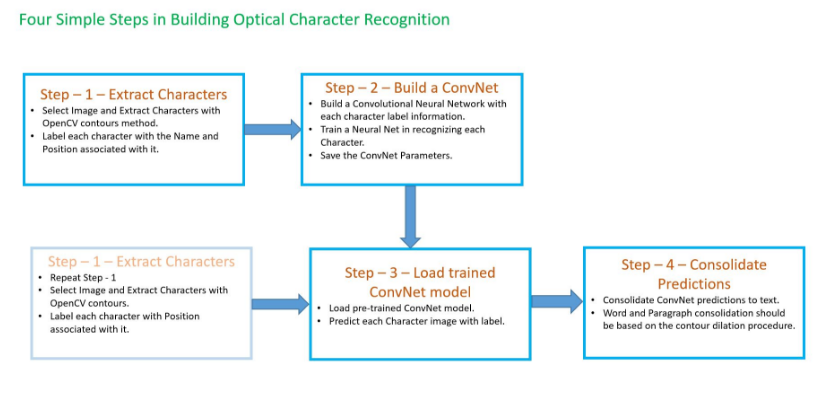

In [2]:
print("Stages of Optical Character Recognition")
Image(filename='OCR_Algorithm.PNG')

## Text extraction from image with Tesseract software

In [3]:
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
file =  r'sample.jpg'
#file = r'output2/sample.jpg'
image = PIL.Image.open(file)
text = pytesseract.image_to_string(image)
print(text)

As he had expected, Mrs. Dursley looked shocked and angry. After all,
they normally pretended she didn't have a sister.

"No," she said sharply. "Why?"

"Funny stuff on the news," Mr. Dursley mumbled. "Owls... shooting
stars... and there were a lot of funny-looking people in town today..."

"So?" snapped Mrs. Dursley.

"Well, I just thought... maybe... it was something to do with... you
know... her crowd."



## Step -1  Extract Characters

## Location Segmentation

The next OCR component is location segmentation. Segmentation determines constituents
of an image. It is necessary to locate regions of document which have
printed data and are distinguished from figures and graphics.

###  Word recogntion through OpenCV

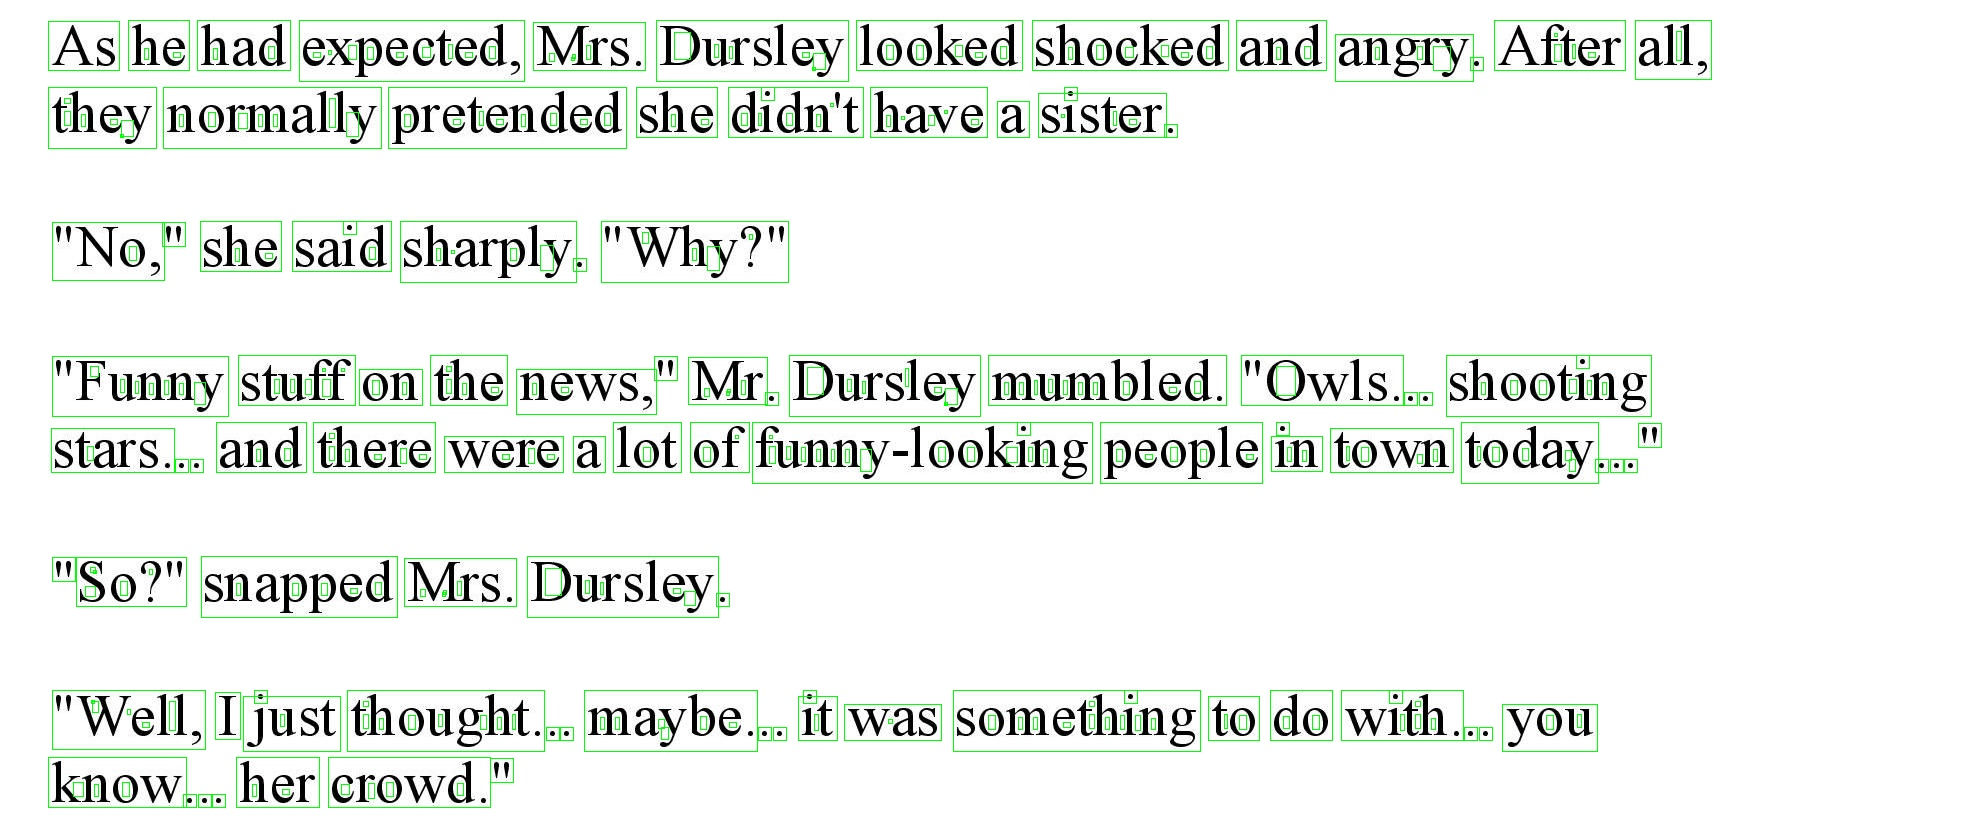

In [4]:
file =  r'sample.jpg'

im1 = cv2.imread(file, 0)
im = cv2.imread(file)

ret,thresh1 = cv2.threshold(im1,180,255,cv2.THRESH_BINARY_INV)
kernel = np.ones((5,5),np.uint8)
dilated = cv2.dilate(thresh1,kernel,iterations = 2)
contours, hierarchy = cv2.findContours(dilated,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cordinates = []
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    cordinates.append((x,y,w,h))
    #bound the images
    cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),1)

# cv2.namedWindow('BindingBox', cv2.WINDOW_NORMAL)
cv2.imwrite('BindingBox4.jpg',im)

from IPython.display import Image
Image(filename='BindingBox4.jpg',width=800,height=400)

In [5]:
import pickle

In [6]:
# open a file, where you ant to store the data
file = open('Cordinates', 'wb')
# dump information to that file
pickle.dump(cordinates, file)
# close the file
file.close()


## Optical Scanning

In OCR optical scanners are used which consist of transport mechanism and sensing device that converts light intensity
into grey levels. Printed documents consist of black print on white background.
When performing OCR multilevel image is converted into bi-level black and white
image. This process known as thresholding is performed on scanner to save memory
space and computational effort. The thresholding process is important as the
results of recognition are totally dependent on quality of bi-level image.

### Character recogntion through OpenCV

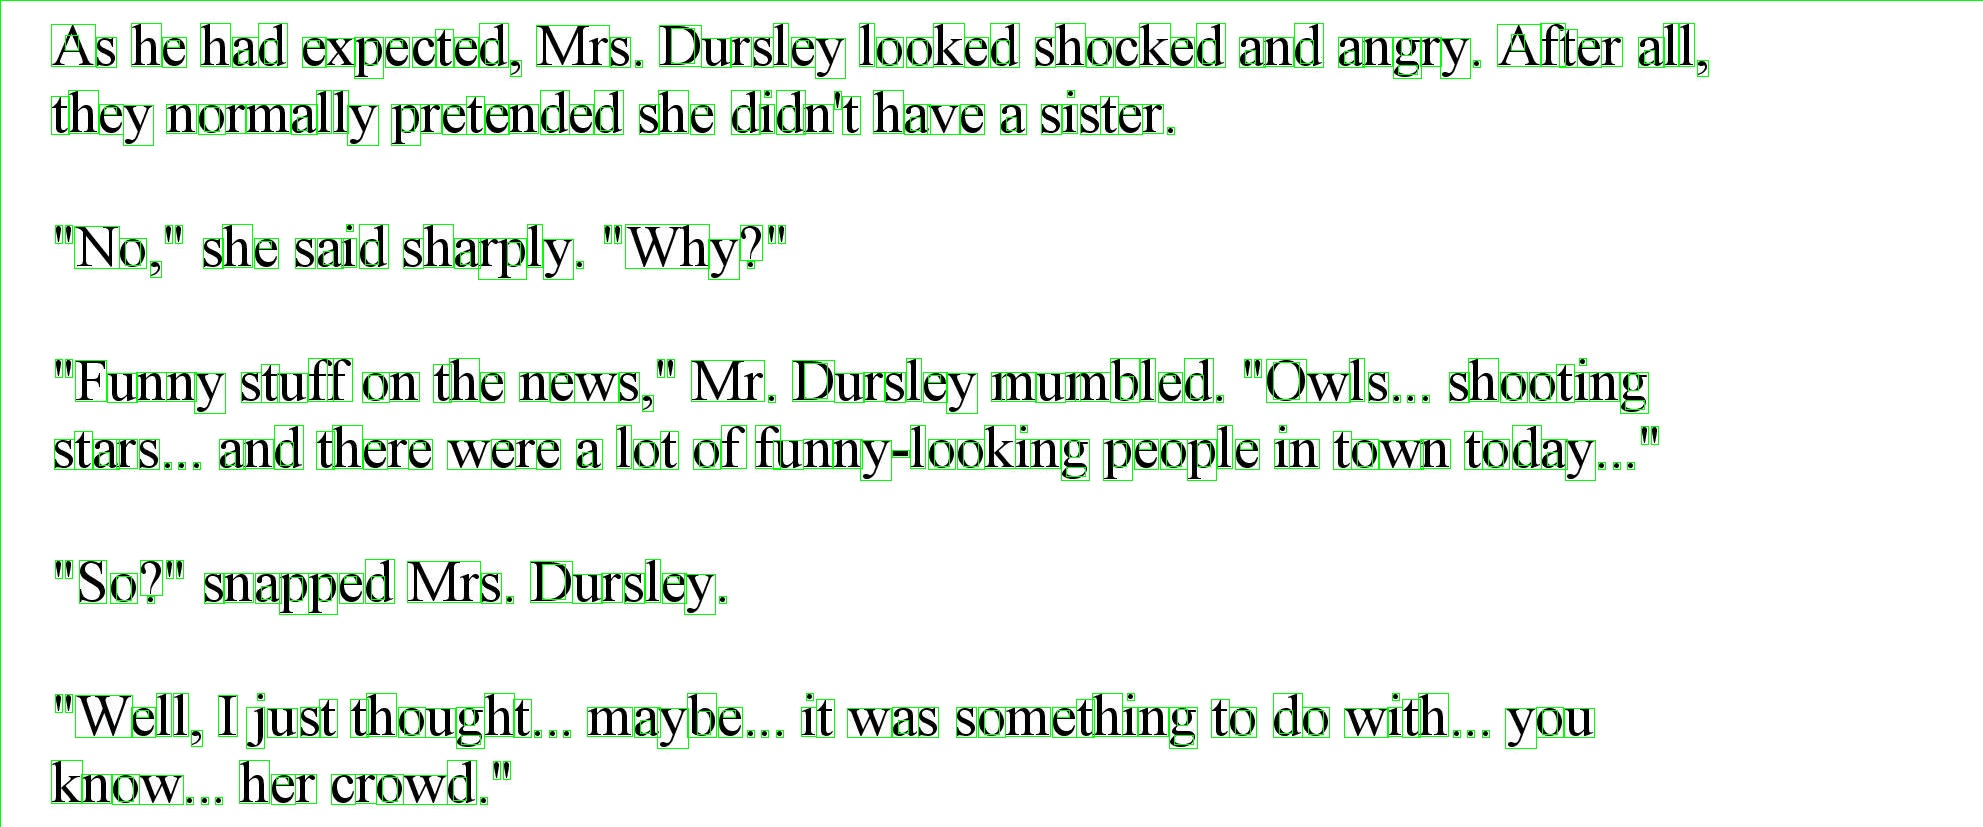

In [7]:
file = r"sample.jpg"
im1 = cv2.imread(file,0)
im = cv2.imread(file)

ret,thresh1 = cv2.threshold(im1,180,278,cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),1)
i=0
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    if w>100 and h>100:
        #save individual images
        cv2.imwrite(str(i)+".jpg",thresh1[y:y+h,x:x+w])
        i=i+1
# cv2.namedWindow('BindingBox', cv2.WINDOW_NORMAL)
cv2.imwrite('BindingBox3.jpg',im)
from IPython.display import Image
Image(filename='BindingBox3.jpg',width=800,height=400)

## Characters recognised through pytesseract (creating boundaries)

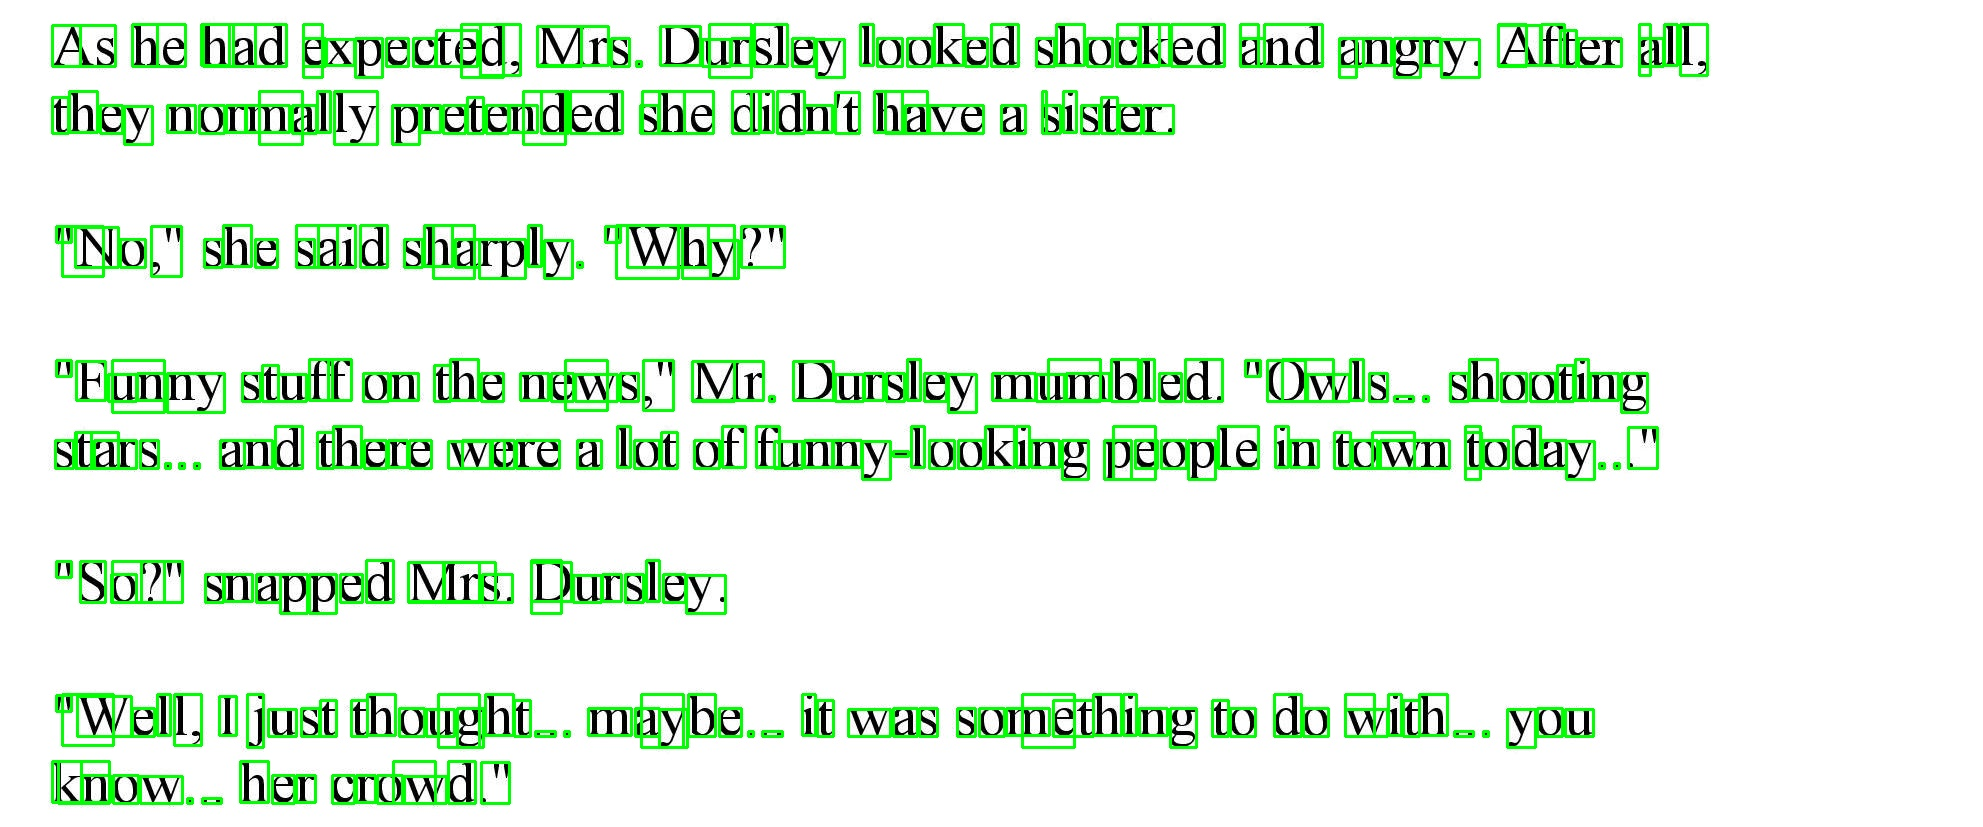

In [8]:
# read the image and get the dimensions
img = cv2.imread(file)
h, w, _ = img.shape # assumes color image

# run tesseract, returning the bounding boxes
boxes = pytesseract.image_to_boxes(img).split('\n') # also include any config options you use
# Box = list(map(lambda box:(box[:1],list(map(int,box[2:][:-2].split(' ')))),boxes))

# draw the bounding boxes on the image
for b in boxes:
    
    b = b.split(' ')
    
    if(len(b)>=5):
        img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)
# show annotated image and wait for keypress
# cv2.imshow(files[0], img)

cv2.imwrite('exboxe.jpg',img)

from IPython.display import Image
Image(filename='exboxe.jpg',width=800,height=400)

In [9]:
4# For each contour, find the bounding rectangle and draw it
count = 0
for component in zip(contours, hierarchy[0]):
    currentContour = component[0]
    currentHierarchy = component[1]
    x,y,w,h = cv2.boundingRect(currentContour)
    if currentHierarchy[3] <= 0:
        # these are the outermost parent components
        cv2.rectangle(im,(x,y),(x+w,y+h),(0,0,128),1)
        count = count + 1
        letter = im[y:y+h,x:x+w]
        # Create a folder of output to store each cropped letter image
        cv2.imwrite('output2/letters/l-{}.jpg'.format(count),letter)
#     elif currentHierarchy[2] < 0:
#         # these are the innermost child components
#         cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),3)

# Finally show the image
cv2.imwrite('img.jpg',im)
print(count)

362


## Step -2 

## Pre-processing

1) The raw data depending on the data
acquisition type is subjected to a number of preliminary processing steps to make it
usable in the descriptive stages of character analysis. The image resulting from scanning
process may contain certain amount of noise

2) Smoothing implies both filling
and thinning. Filling eliminates small breaks, gaps and holes in digitized characters
while thinning reduces width of line.

    (a) noise reduction

    (b) normalization of the data and

    (c) compression in the amount of information to be retained.

### a.  Noise Reduction
Noise reduction: The noise introduced by the optical scanning device or the
writing instrument causes disconnected line segments, bumps and gaps in
lines, filled loops, etc. The distortion including local variations, rounding of
corners, dilation and erosion is a potential problem.
    
    (i) filtering
    (ii) morphological operations and 
    (iii) noise modeling.

### b. Normalization: 
The normalization methods aim to remove the variations of the
writing and obtain standardized data. Some of the commonly used methods
for normalization are 
    
    (i) skew normalization and baseline extraction
    (ii) slant normalization 
    (iii) size normalization and 
    (iv) contour smoothing

### Naming Convention followed
the extracted Text characters should be labelled with the Original character associated with it. 

Here the Naming convention followed for the letters is last letter of file name should be the name associated with the character.

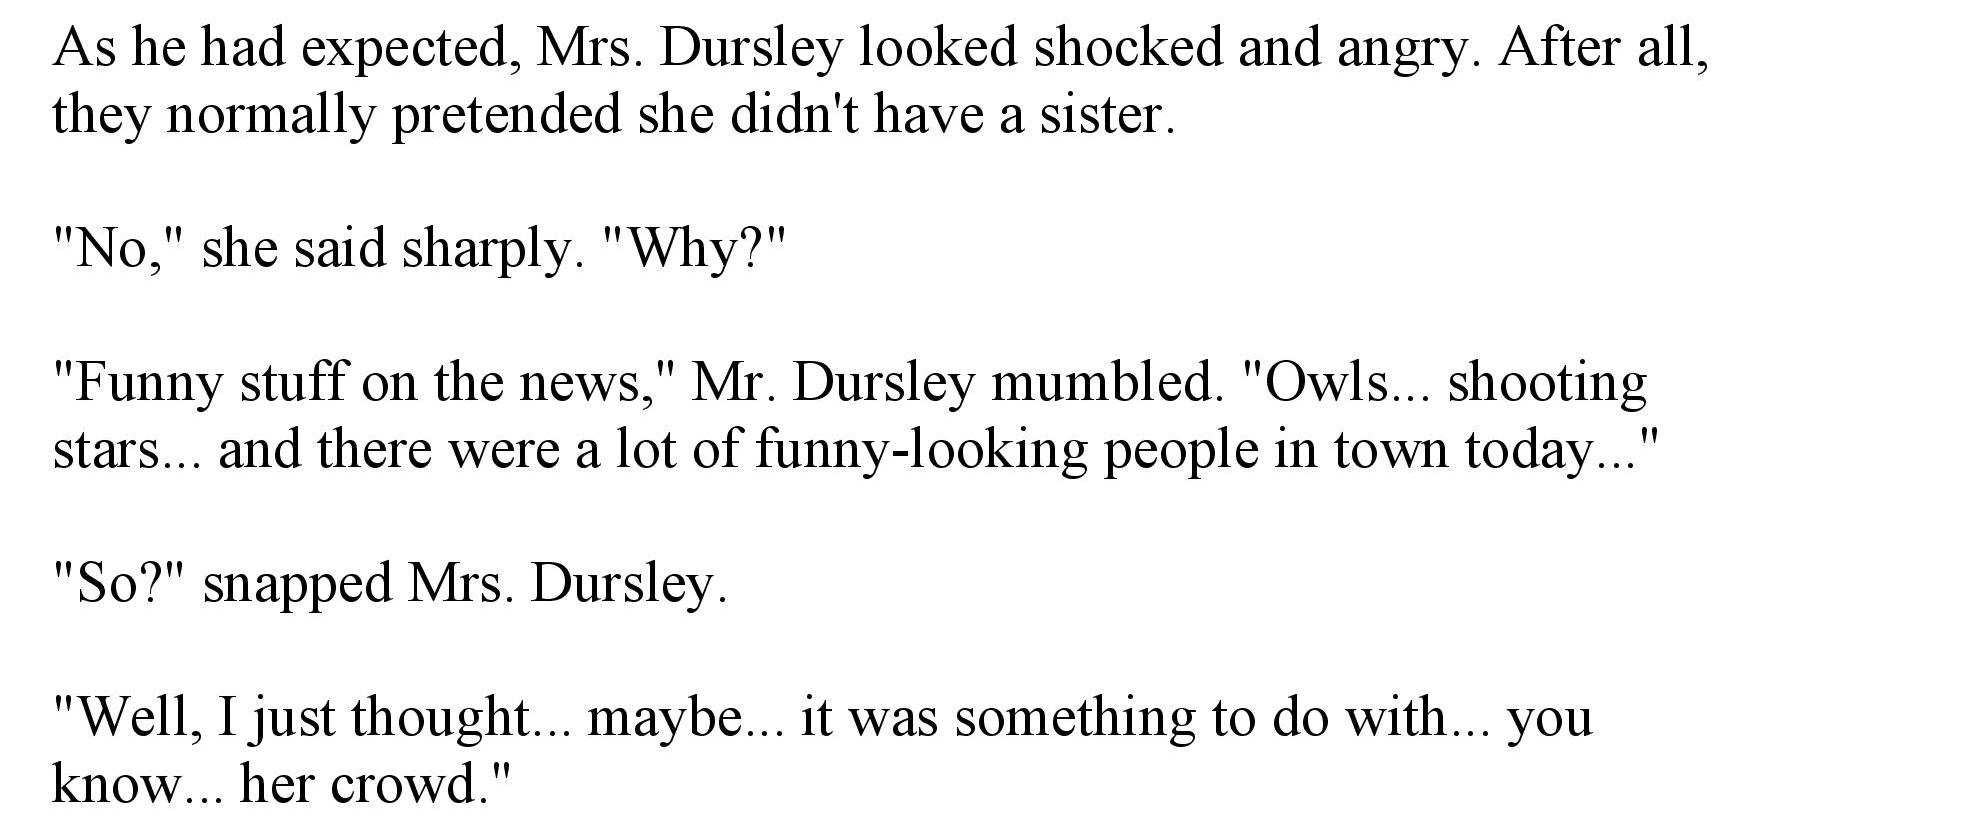

In [10]:
Image(filename='sample.jpg',width=650,height=400)

In [11]:
decod_y = json.load(open("Model/decod.txt"))
decod_y = {int(k):v for k, v in decod_y.items()}

model_path = "Model\model"

# load json and create model
json_file = open(model_path+'.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(model_path+".h5")
print("Loaded model from disk")

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics = [auc_pr]) 

Loaded model from disk


In [12]:
from PIL import Image

In [39]:
a = 'output/134-0.jpg'
im = PIL.Image.open(a)
b = np.array(im.resize([32,32], PIL.Image.ANTIALIAS))
d = b[None,:,:,:]
print(b.shape)
print(d.shape)
# model.summary()
c = model.predict(d)
print(c)
print(decod_y[np.argmax(c)])

(32, 32, 3)
(1, 32, 32, 3)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
a


In [14]:
def Text_of_Character():
    a = 'letraAislada.jpg'
    im = PIL.Image.open(a)
    b = np.array(im.resize([32,32],PIL.Image.ANTIALIAS))
    print(b.shape)
    d = b[None,:,:,:]
    c = model.predict(d)
    print(c)
    return decod_y[np.argmax(c)]
Text_of_Character()

(32, 32, 3)
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


'.'

In [40]:
def get_contour_precedence(contour, cols):
    tolerance_factor = 10
    origin = cv2.boundingRect(contour)
    return ((origin[1] // tolerance_factor) * tolerance_factor) * cols + origin[0]

In [16]:
file = r"sample.jpg"
im1 = cv2.imread(file,0)
im = cv2.imread(file)

ret,thresh1 = cv2.threshold(im1,180,278,cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),1)
i=0

sorted_ctrs = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0] + cv2.boundingRect(ctr)[1] * im1.shape[1] )
# x + y * w

text = ""
once = True

for cnt in sorted_ctrs:
    x,y,w,h = cv2.boundingRect(cnt)
    # if w>100 and h>100:
        #save individual images
    # print(i)
    if(once):
        once = False
        continue
    cv2.imwrite("letraAislada.jpg",im[y:y+h,x:x+w])
    char = Text_of_Character()
    text = text + char +" "   
    # cv2.imwrite("output/"+str(i)+".jpg",thresh1[y:y+h,x:x+w])
    i=i+1
# cv2.namedWindow('BindingBox', cv2.WINDOW_NORMAL)
cv2.imwrite('BindingBox3.jpg',im)
from IPython.display import Image
Image(filename='BindingBox3.jpg',width=800,height=400)
print(text)

(32, 32, 3)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(32, 32, 3)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(32, 32, 3)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(32, 32, 3)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(32, 32, 3)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(32, 32, 3)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(32, 32, 3)
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.00

In [44]:
file =  r'sample.jpg'

im1 = cv2.imread(file, 0)
im = cv2.imread(file)

ret,thresh1 = cv2.threshold(im1,180,255,cv2.THRESH_BINARY_INV)
kernel = np.ones((5,5),np.uint8)
dilated = cv2.dilate(thresh1,kernel,iterations = 2)
contours, hierarchy = cv2.findContours(dilated,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
print(contours)
contours.sort(key=lambda x:get_contour_precedence(x, im1.shape[1]))
text = ''
i=0
for cnt in contours:
    j=0
    a,b,c,d = cv2.boundingRect(cnt)
    if ((c*d)/(im1.shape[0]*im1.shape[1])) > 0.00005:
        #bound the images
        cv2.rectangle(im,(a,b),(a+c,b+d),(0,255,0),1)
        
        
        
        letter = im[b:b+d,a:a+c]
        cv2.imwrite('output/'+str(i)+'.jpg',letter)
        i=i+1
        cv2.imwrite('data/sample.jpg',letter)
        im2 = cv2.imread('data/sample.jpg', 0)
        # pause()
        ret,thresh1 = cv2.threshold(im2,180,255,cv2.THRESH_BINARY_INV)
        kernel = np.ones((1,1),np.uint8)
        dilated = cv2.dilate(thresh1,kernel,iterations = 2)
        contours1, hierarchy1 = cv2.findContours(dilated,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        contours1.sort(key=lambda x:get_contour_precedence(x, im2.shape[1]))
        sorted_ctrs1 = sorted(contours1, key=lambda ctr1: cv2.boundingRect(ctr1)[0] + cv2.boundingRect(ctr1)[1] * im2.shape[1] )


        for cnt1 in contours1:
            x,y,w,h = cv2.boundingRect(cnt1)
            #print(h,w)
            #print('shape',im2.shape)
            if ((h>0.4*im2.shape[0]) & (h*w < 0.5*im2.shape[0]*im2.shape[1])):
                #print('in')
                #bound the images
                cv2.rectangle(im,(a+x,b+y),(a+x+w,b+y+h),(0,255,0),1)
                cv2.imwrite('output/'+str(i)+'-'+str(j)+'.jpg',im[b+y:b+y+h,a+x:a+x+w])
                j=j+1
                cv2.imwrite('letraAislada.jpg',im[b+y:b+y+h,a+x:a+x+w])
                char = Text_of_Character()
                text = text + char    
            text = text +' '

# cv2.namedWindow('BindingBox', cv2.WINDOW_NORMAL)
cv2.imwrite('data/BindingBox4.jpg',im)

from IPython.display import Image
Image(filename='data/BindingBox4.jpg',width=800,height=400)

(array([[[213, 794]],

       [[212, 795]],

       [[212, 805]],

       [[213, 806]],

       [[223, 806]],

       [[224, 805]],

       [[224, 795]],

       [[223, 794]]], dtype=int32), array([[[199, 794]],

       [[198, 795]],

       [[198, 805]],

       [[199, 806]],

       [[209, 806]],

       [[210, 805]],

       [[210, 795]],

       [[209, 794]]], dtype=int32), array([[[184, 794]],

       [[183, 795]],

       [[183, 805]],

       [[184, 806]],

       [[194, 806]],

       [[195, 805]],

       [[195, 795]],

       [[194, 794]]], dtype=int32), array([[[491, 758]],

       [[490, 759]],

       [[490, 774]],

       [[491, 775]],

       [[491, 779]],

       [[492, 780]],

       [[492, 781]],

       [[500, 781]],

       [[500, 780]],

       [[501, 779]],

       [[502, 780]],

       [[502, 781]],

       [[510, 781]],

       [[510, 780]],

       [[511, 779]],

       [[511, 775]],

       [[512, 774]],

       [[512, 759]],

       [[511, 758]]], dtype=int32

AttributeError: 'tuple' object has no attribute 'sort'

In [27]:
text

' b U   b d a m   d d U p U U U  v   m D   _ . D r s U U  y  _ c d o o U v v  m  b c d s o U U v  m  d a ! m   r n d  U r   _ _ a    n  s   s      a ! v  r y         v    b d U  y  _ _ ! o r p a v v   d d d p r U U ! U   m  m D  b s U   d  d  d _ ! m m    b a U v       d s _ s U r     1         b s U    d s a _ m     b _ s a p y U   w   p   v     v o v   w w      f r d s U  b d U   _ . U r s U U  v  b _ d p p U U  m r   _   . m s w   b  d s o o _ ! v  v v       v ! ! U v  w w       o ! v  ! U s  w           v       d a ! m   b d U r U    _ d o v  r o v  f _ c  ! ! o o _ ! v  U v v v      _ p U o p U  v  D D    d d o a v m y   w w  d s r s    d o v v   U r U w     1  _ !                        d s ! a p p U  m D U   _ . D r s U U  v  w w  s p   o v    s          _ _   w U      b b d d o v  v U    b p a U v  r      b  d s o p U _ ! v  v      d o m v   b d _ w        d r s U   d _  d o v   a s w 1  o v v U                     c ! o v w  b U r   d U r o v w m   w w          '

In [19]:
from IPython.core.debugger import set_trace

In [20]:
file =  r'data/sample.jpg'

im = cv2.imread(file)

ret,thresh1 = cv2.threshold(im2,180,255,cv2.THRESH_BINARY_INV)
kernel = np.ones((1,1),np.uint8)
dilated = cv2.dilate(thresh1,kernel,iterations = 2)
contours1, hierarchy1 = cv2.findContours(dilated,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cordinates = []
for cnt1 in contours1:
    x,y,w,h = cv2.boundingRect(cnt1)
    cordinates.append((x,y,w,h))
    if (((h*w)/(im1.shape[0]*im1.shape[1])) > 0.0005) & (h>0.5*im1.shape[0]) & (h*w < 0.7*im1.shape[0]*im1.shape[1]):
        print(h,im1.shape[1])
        #bound the images
        cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),1)
        set_trace()

# cv2.namedWindow('BindingBox', cv2.WINDOW_NORMAL)
cv2.imwrite('data/BindingBox4.jpg',im)

from IPython.display import Image
Image(filename='data/BindingBox4.jpg',width=800,height=400)

In [21]:
im1 = cv2.imread(file,0)
im = cv2.imread(file)

ret,thresh1 = cv2.threshold(im1,180,278,cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),1)
i=0
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    if w>100 and h>100:
        #save individual images
        cv2.imwrite(str(i)+".jpg",thresh1[y:y+h,x:x+w])
        i=i+1
# cv2.namedWindow('BindingBox', cv2.WINDOW_NORMAL)
cv2.imwrite('data/BindingBox3.jpg',im)
from IPython.display import Image
Image(filename='data/BindingBox3.jpg',width=800,height=400)

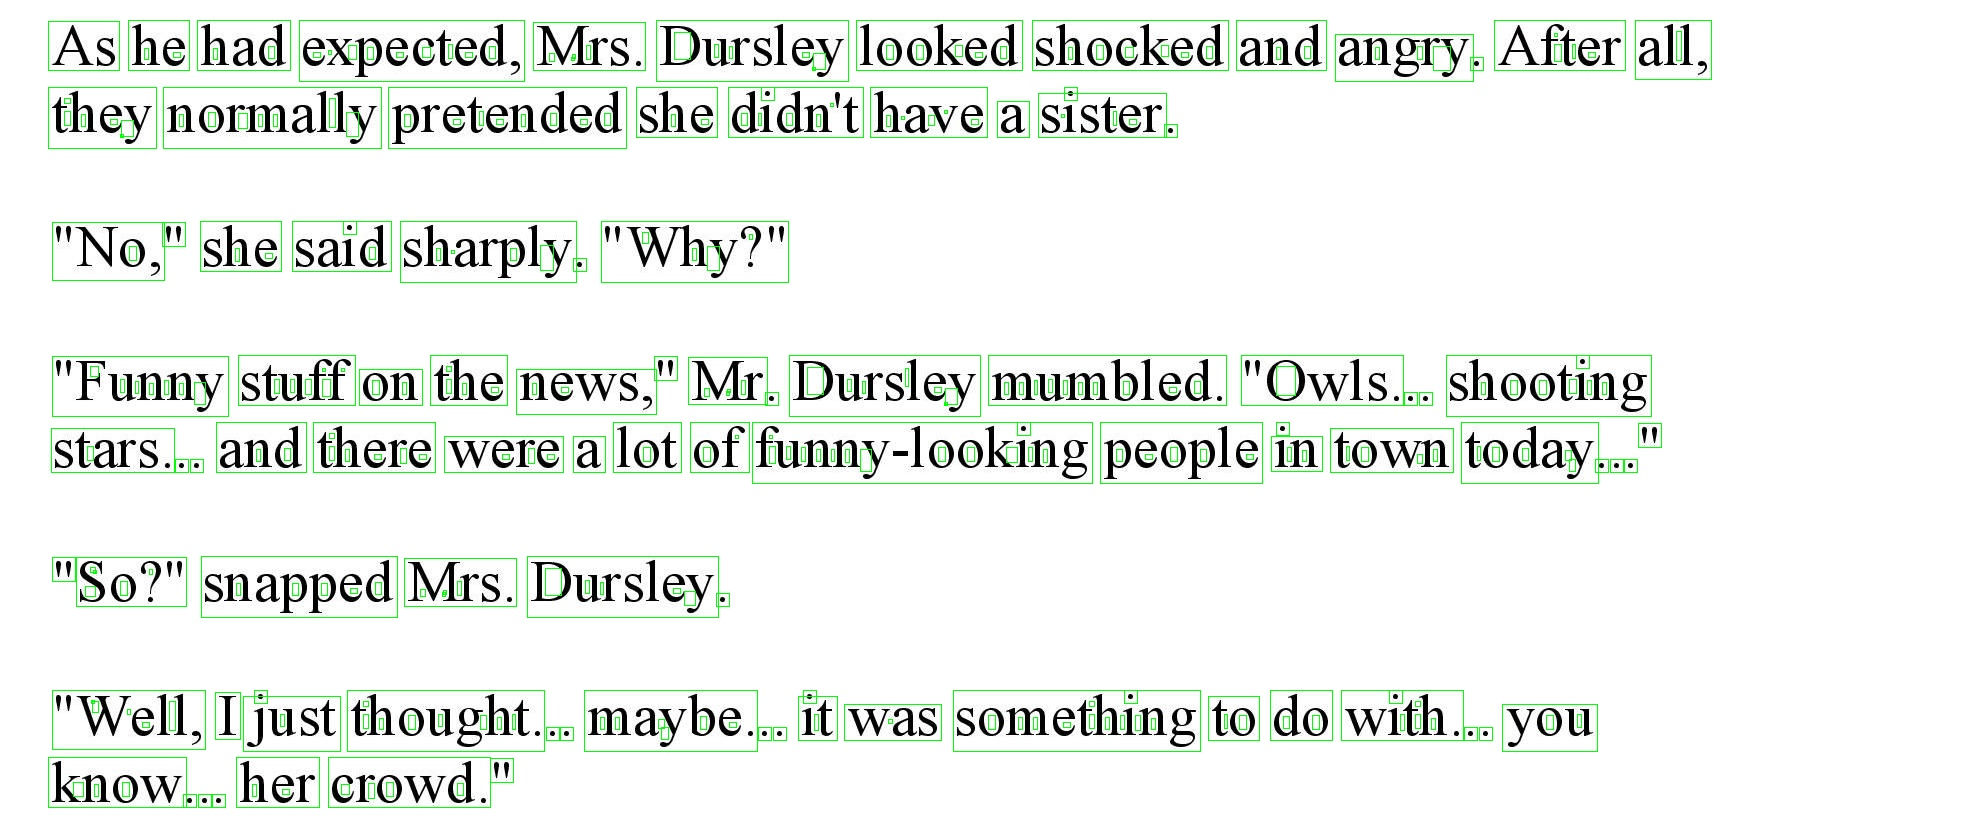

In [22]:
file =  r'sample.jpg'

im1 = cv2.imread(file, 0)
im = cv2.imread(file)

ret,thresh1 = cv2.threshold(im1,180,255,cv2.THRESH_BINARY_INV)
kernel = np.ones((5,5),np.uint8)
dilated = cv2.dilate(thresh1,kernel,iterations = 2)
contours, hierarchy = cv2.findContours(dilated,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cordinates = []
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    cordinates.append((x,y,w,h))
    #bound the images
    cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),1)

# cv2.namedWindow('BindingBox', cv2.WINDOW_NORMAL)
cv2.imwrite('data/BindingBox4.jpg',im)

from IPython.display import Image
Image(filename='data/BindingBox4.jpg',width=800,height=400)